In [1]:
import numpy as np
import pandas as pd

import utils
from sklearn.metrics.pairwise import paired_distances
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns 

import torch
from alive_progress import alive_bar, alive_it




In [16]:
import importlib
importlib.reload(utils)


<module 'utils' from '/home/acercyc/projects/Keio Testing_analysis/src/utils.py'>

In [2]:
subjs = utils.ExpInfo.getSubjIDs()
task = utils.ExpInfo.taskName[2]


# Identify the subject with the best performance in no-noise trial

In [3]:
task = utils.ExpInfo.taskName[2]
df_beh_all = [utils.LoadData.behaviorData(x, task) for x in subjs]
df_beh_all = pd.concat(df_beh_all)

In [6]:
df_ = df_beh_all.query('`actual control`==1')
df_ = df_[['participant', 'number of reaching', 'group']]
df_ = df_.groupby(['participant', 'group']).mean().reset_index()
df_noNoise = df_.sort_values(by='number of reaching', ascending=False)
topSubj = df_noNoise.reset_index()['participant'][0]
topSubj

'K-Reg-H-25'

## Extract motion data from the best subject

In [7]:
df_beh = utils.LoadData.behaviorData(topSubj, task)
trials_noNoise = np.where(df_beh['actual control'] == 1)[0]

wSize = 60
x, x_disp = utils.LoadData.mouseMovement_array(topSubj, task)
x_top = [utils.DataProcessing.rollingWindow(x[iTrial], wSize) for iTrial in trials_noNoise]

# Get hidden state by passing motion trajectories of the best subject to other subjects

In [8]:
# h: [subj][trial]
h = []
for subj in alive_it(subjs, force_tty=True, title='Group loop'):
    h_, _ = utils.Model.quick_forward(subj, x_top)
    h.append(h_)
    

Group loop |████████████████████████████████████████| 50/50 [100%] in 1:13.7 (0.68/s)                                   


## SD analysis

In [9]:
nTrial = len(h[0])
h_sd = []
for iTrial in range(nTrial):
    h_sd_trial = []
    for iSubj in range(len(h)):
        h_sd_trial.append(h[iSubj][iTrial].std())
    h_sd.append(h_sd_trial)

In [10]:
h_sd_mean = np.array(h_sd).mean(axis=0)
nReach = df_noNoise.sort_index()['number of reaching'].values
from scipy.stats import pearsonr
pearsonr(nReach, h_sd_mean)


(-0.36899772697557687, 0.008364576230626987)

<AxesSubplot:xlabel='SD of hidden state position', ylabel='number of reaching'>

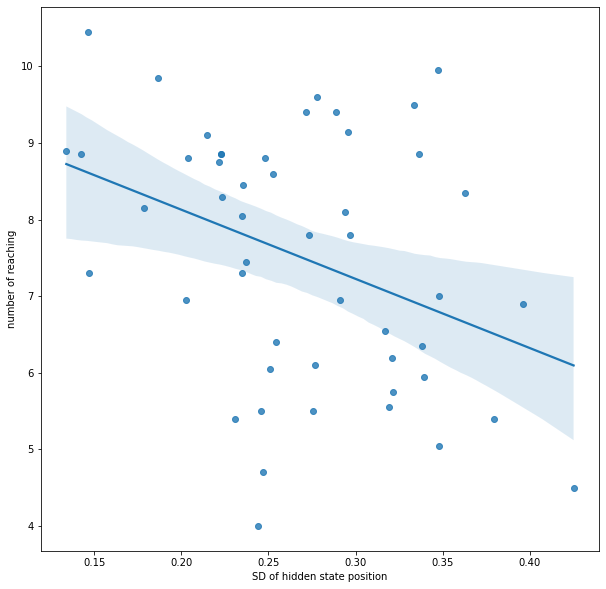

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
df_ = pd.DataFrame({'number of reaching': nReach, 'SD of hidden state position': h_sd_mean})
sns.regplot(y='number of reaching', x='SD of hidden state position', data=df_)
# ax.plot(h_sd_mean, nReach, 'o')

# Traveling distance

In [43]:
nTrial = len(h[0])
h_trav_dist = []
for iTrial in range(nTrial):
    d = []
    for iSubj in range(len(h)):
        d.append(utils.DataProcessing.diff(h[iSubj][iTrial]).mean())
    h_trav_dist.append(d)

In [44]:
h_trav_dist = np.array(h_trav_dist).mean(axis=0)
nReach = df_noNoise.sort_index()['number of reaching'].values
from scipy.stats import pearsonr
pearsonr(nReach, h_trav_dist)


(-0.2670940297664209, 0.06077965934748523)

# Pairwise_distances

In [16]:
nTrial = len(h[0])
h_dist = []
for iTrial in range(nTrial):
    d = []
    for iSubj in range(len(h)):
        d_ = h[iSubj][iTrial]
        d.append(pairwise_distances(d_, metric='euclidean').std())
    h_dist.append(d)

In [17]:
# corr
h_dist_ = np.array(h_dist).mean(axis=0)
nReach = df_noNoise.sort_index()['number of reaching'].values
pearsonr(nReach, h_dist_)

(-0.36682553107898297, 0.008785738050730418)

In [14]:
# corr by group
df_noNoise_ = df_noNoise.sort_index()
ig = df_noNoise_['group'] == 'H'
nReach = df_noNoise_[ig]['number of reaching'].values
print(pearsonr(nReach, h_dist_[ig]))
ig = df_noNoise_['group'] == 'S'
nReach = df_noNoise_[ig]['number of reaching'].values
print(pearsonr(nReach, h_dist_[ig]))

# df_noNoise.query('group=="H"').sort_index()['number of reaching'].values

(0.14465723764172383, 0.49025770619841846)
(-0.2239245693523811, 0.28190913406930435)


<AxesSubplot:xlabel='SD of hidden state position', ylabel='number of reaching'>

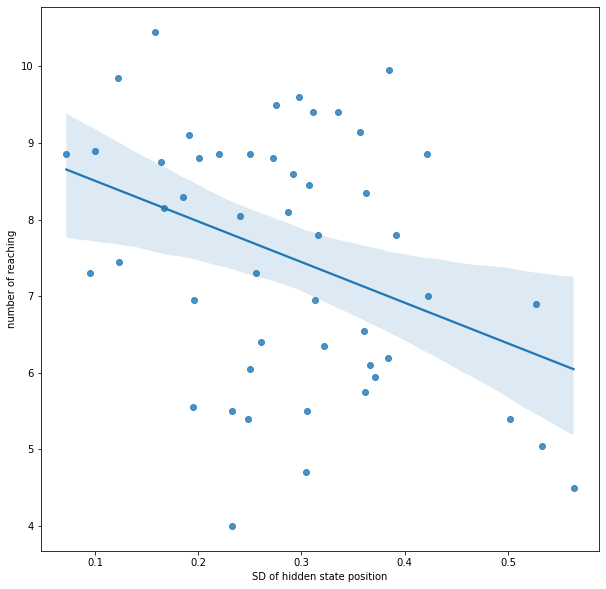

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
df_ = pd.DataFrame({'number of reaching': nReach, 'SD of hidden state position': h_dist_})
sns.regplot(y='number of reaching', x='SD of hidden state position', data=df_)
# ax.plot(h_sd_mean, nReach, 'o')

<AxesSubplot:xlabel='SD of paired_distances', ylabel='number of reaching'>

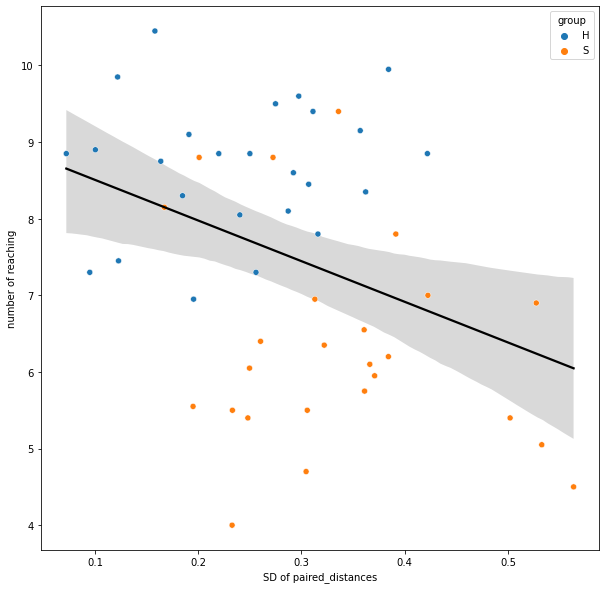

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
# df_ = pd.DataFrame({'number of reaching': nReach, 'SD of paired_distances': h_dist_})]
df_ = df_noNoise_.copy()
df_['SD of paired_distances'] = h_dist_
sns.regplot(y='number of reaching', x='SD of paired_distances', data=df_, scatter_kws={'s':2}, color='k')
# sns.pairplot(data=df_, hue='group', kind='reg')
sns.scatterplot(y='number of reaching', x='SD of paired_distances', data=df_, hue='group')


# ax.plot(h_sd_mean, nReach, 'o')

In [67]:
# t-test on SD
from statsmodels.stats.weightstats import ttest_ind
df_noNoise_ = df_noNoise.sort_index()
d1 = h_dist_[df_noNoise_['group'] == 'H']
d2 = h_dist_[df_noNoise_['group'] == 'S']
ttest_ind(d1, d2, alternative='smaller')

(-3.334893422733496, 0.0008259155496934166, 48.0)